In [10]:
!pip uninstall -y basicpy

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


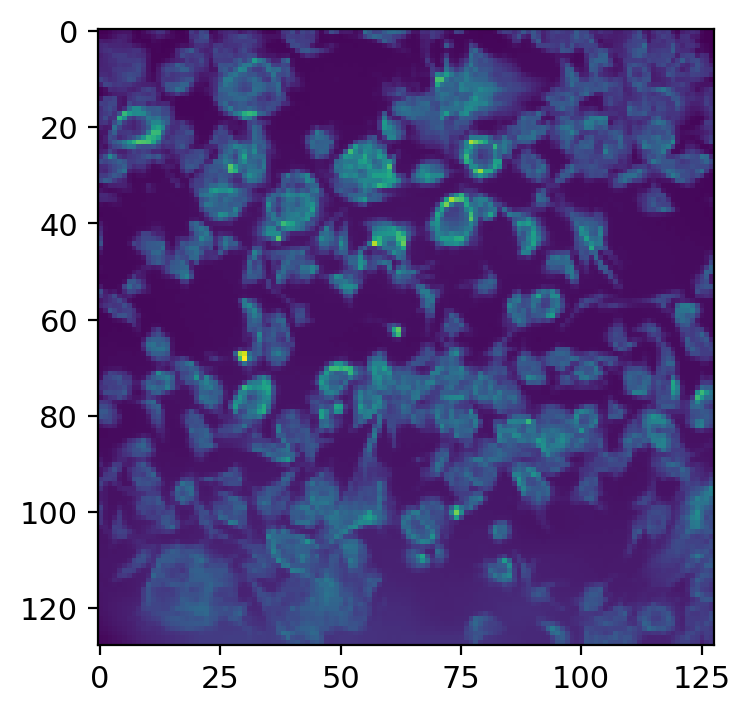

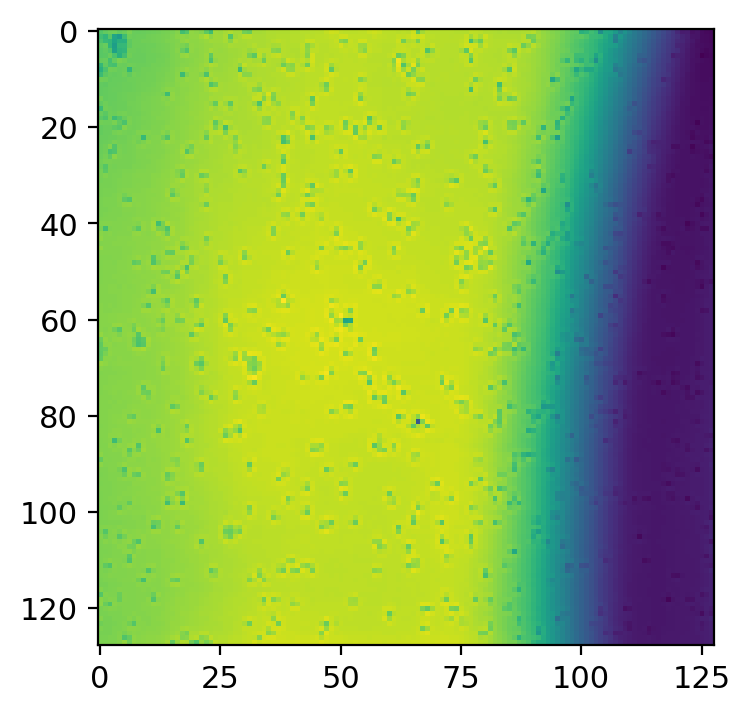

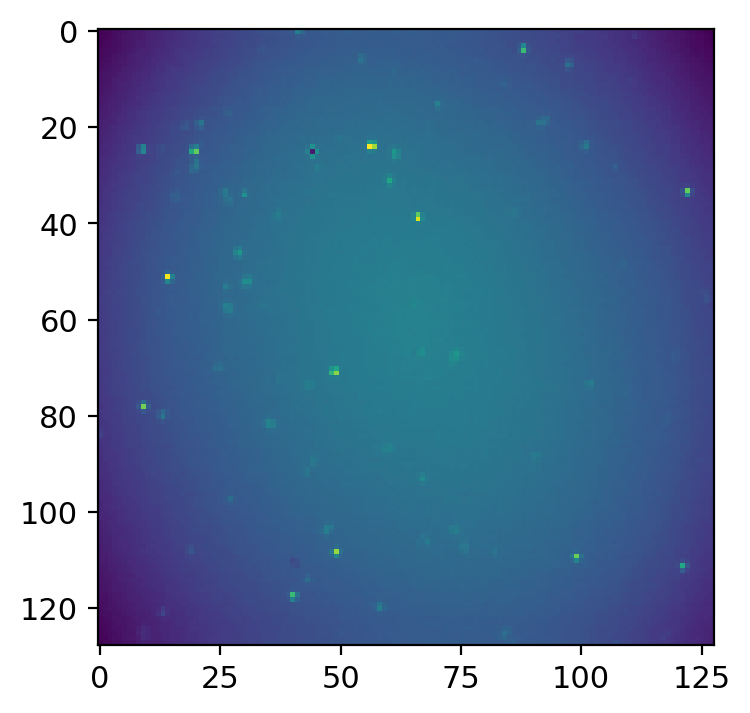

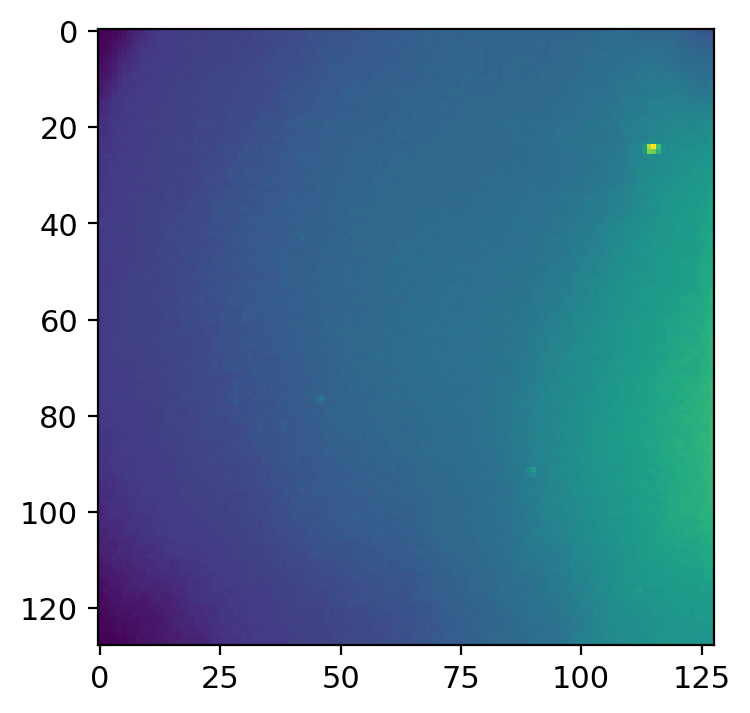

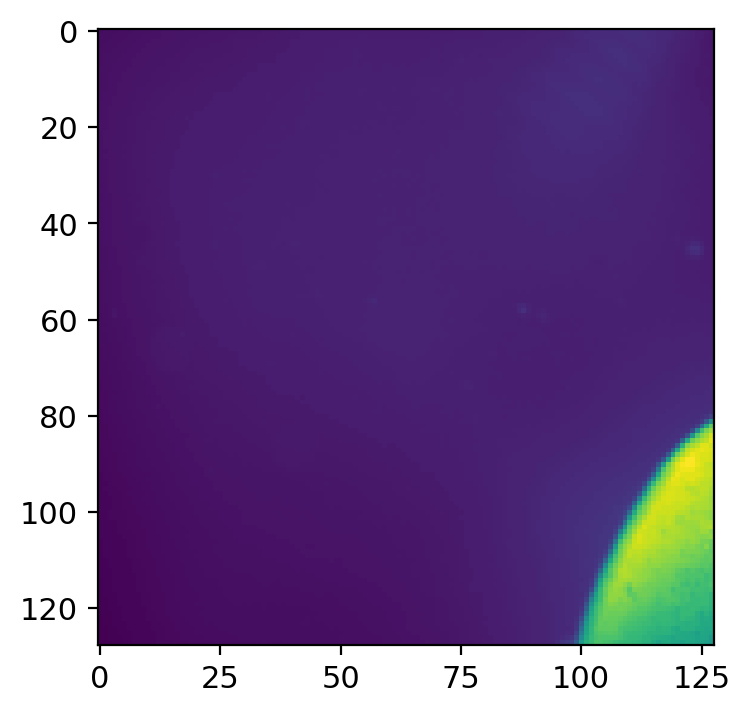

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize as skresize
import sys
sys.path.append("../")
RESIZE_ORDER = 1
RESIZE_MODE = "symmetric"
_preserve_range = True

keys = ["cell_culture","timelapse_brightfield","timelapse_nanog","timelapse_pu1","wsi_brain"]
def _resize_images_list(images_list, 
                        side_size: float = None, 
                        x_side_size: float = None, 
                        y_side_size: float = None):
    if side_size is not None:
        y_side_size = x_side_size = side_size
    resized_images_list = []
    for i, im in enumerate(images_list):
        if im.shape[0] != x_side_size or im.shape[1] != y_side_size:
            resized_images_list.append(skresize(
                im, 
                (x_side_size, y_side_size), 
                order = RESIZE_ORDER, 
                mode = RESIZE_MODE,
                preserve_range = _preserve_range
                )
            )
        else:
            resized_images_list.append(im)
    return resized_images_list

imagess = {}
for k in keys:
    images = np.load("../data/{}.npz".format(k))["images"]
    images=_resize_images_list(images,side_size=128)
    imagess[k] = np.array(images).astype(np.float32)
    plt.imshow(images[10])
    plt.show()

In [15]:
d.keys()

dict_keys(['flatfield', 'darkfield', 'baseline', 'flatfield-flatonly', 'darkfield-flatonly', 'baseline-flatonly'])

INFO:basicpy.basicpy:Initializing BaSiC 4809312704 with parameters: 
fitting_mode: approximate
working_size: None
get_darkfield: True
sort_intensity: True

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 5.68631094211014e-07.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 6.040444304744597e-07.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.09980791062116623
INFO:basicpy.basicpy:elapsed time: 2.9339485099999365 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 6.050983643035579e-07.
INFO:basicpy.basicpy:Iteration 2 finished.
INFO:basicpy.basicpy:reweighting score: 0.005573756527155638
INFO:basicpy.basicpy:elapsed time: 3.7974067000000105 seconds
INFO:basicpy.basicpy:Reweighting converged.
INFO:basicpy.basi

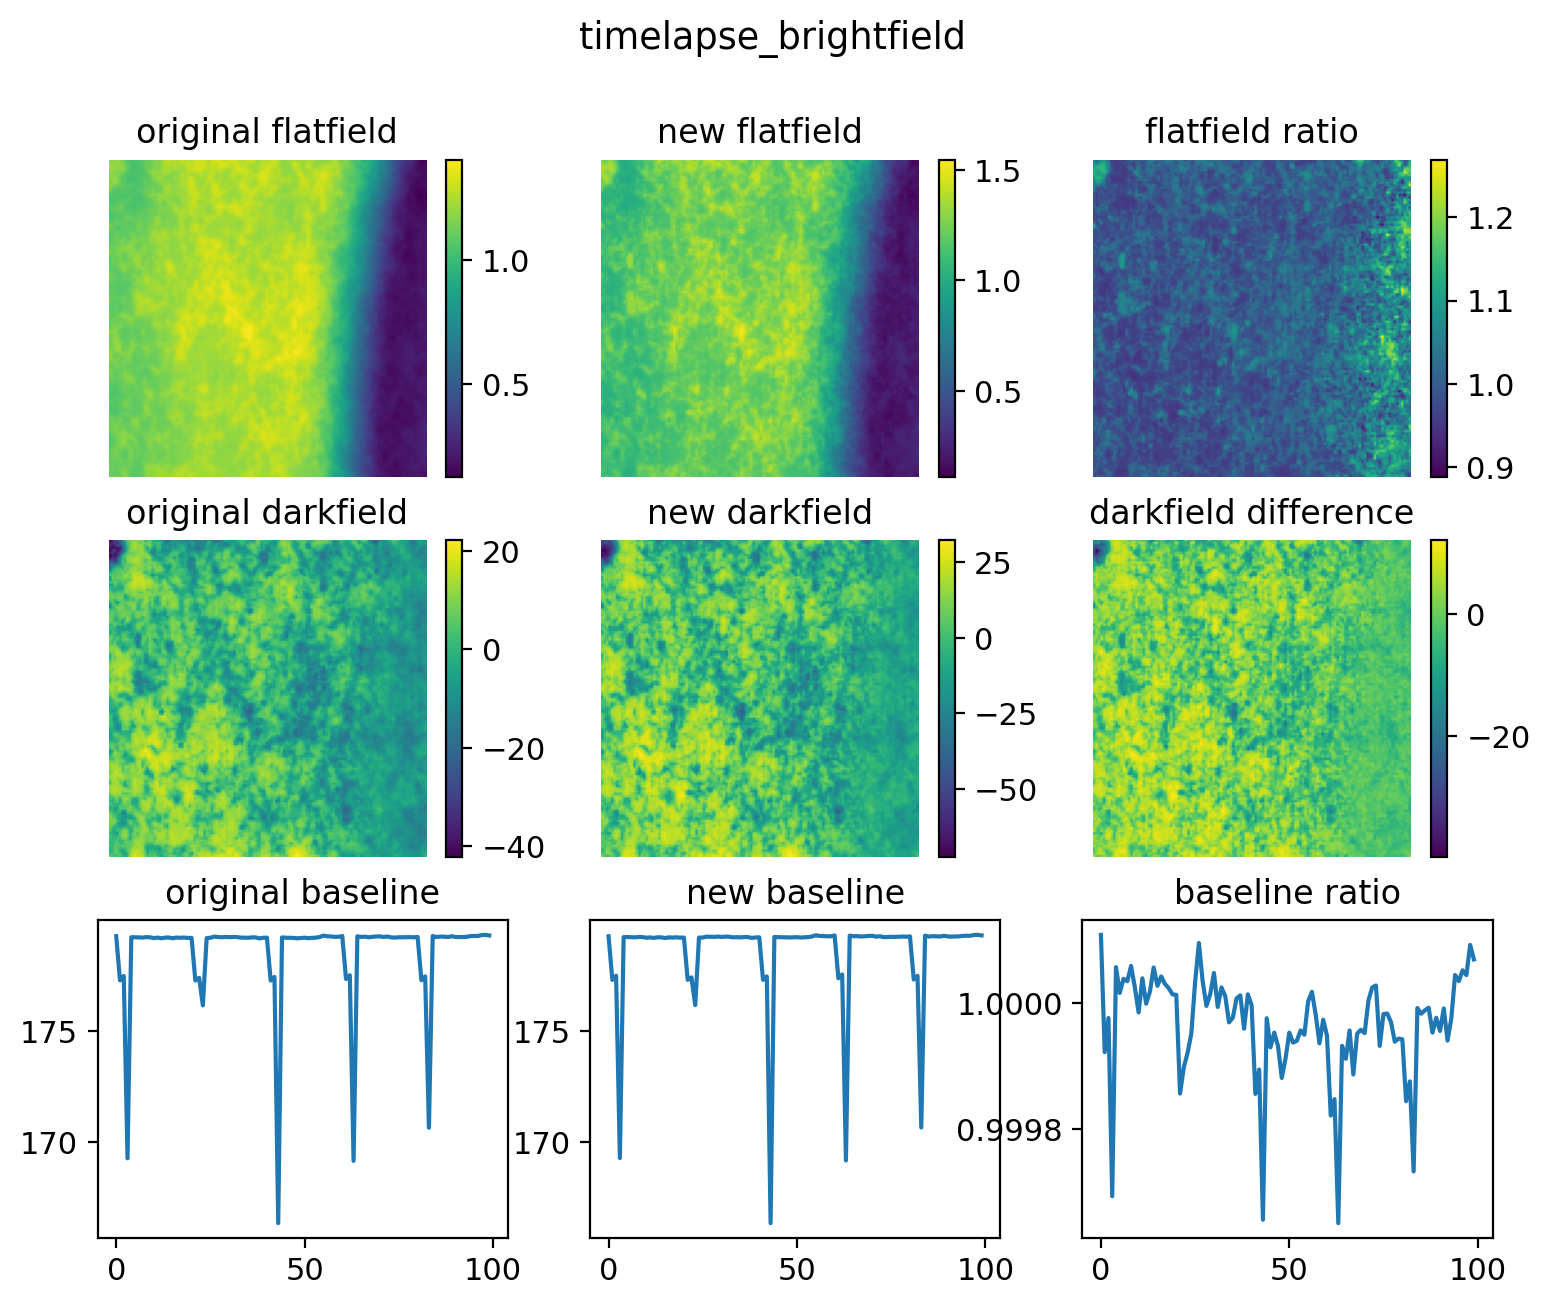

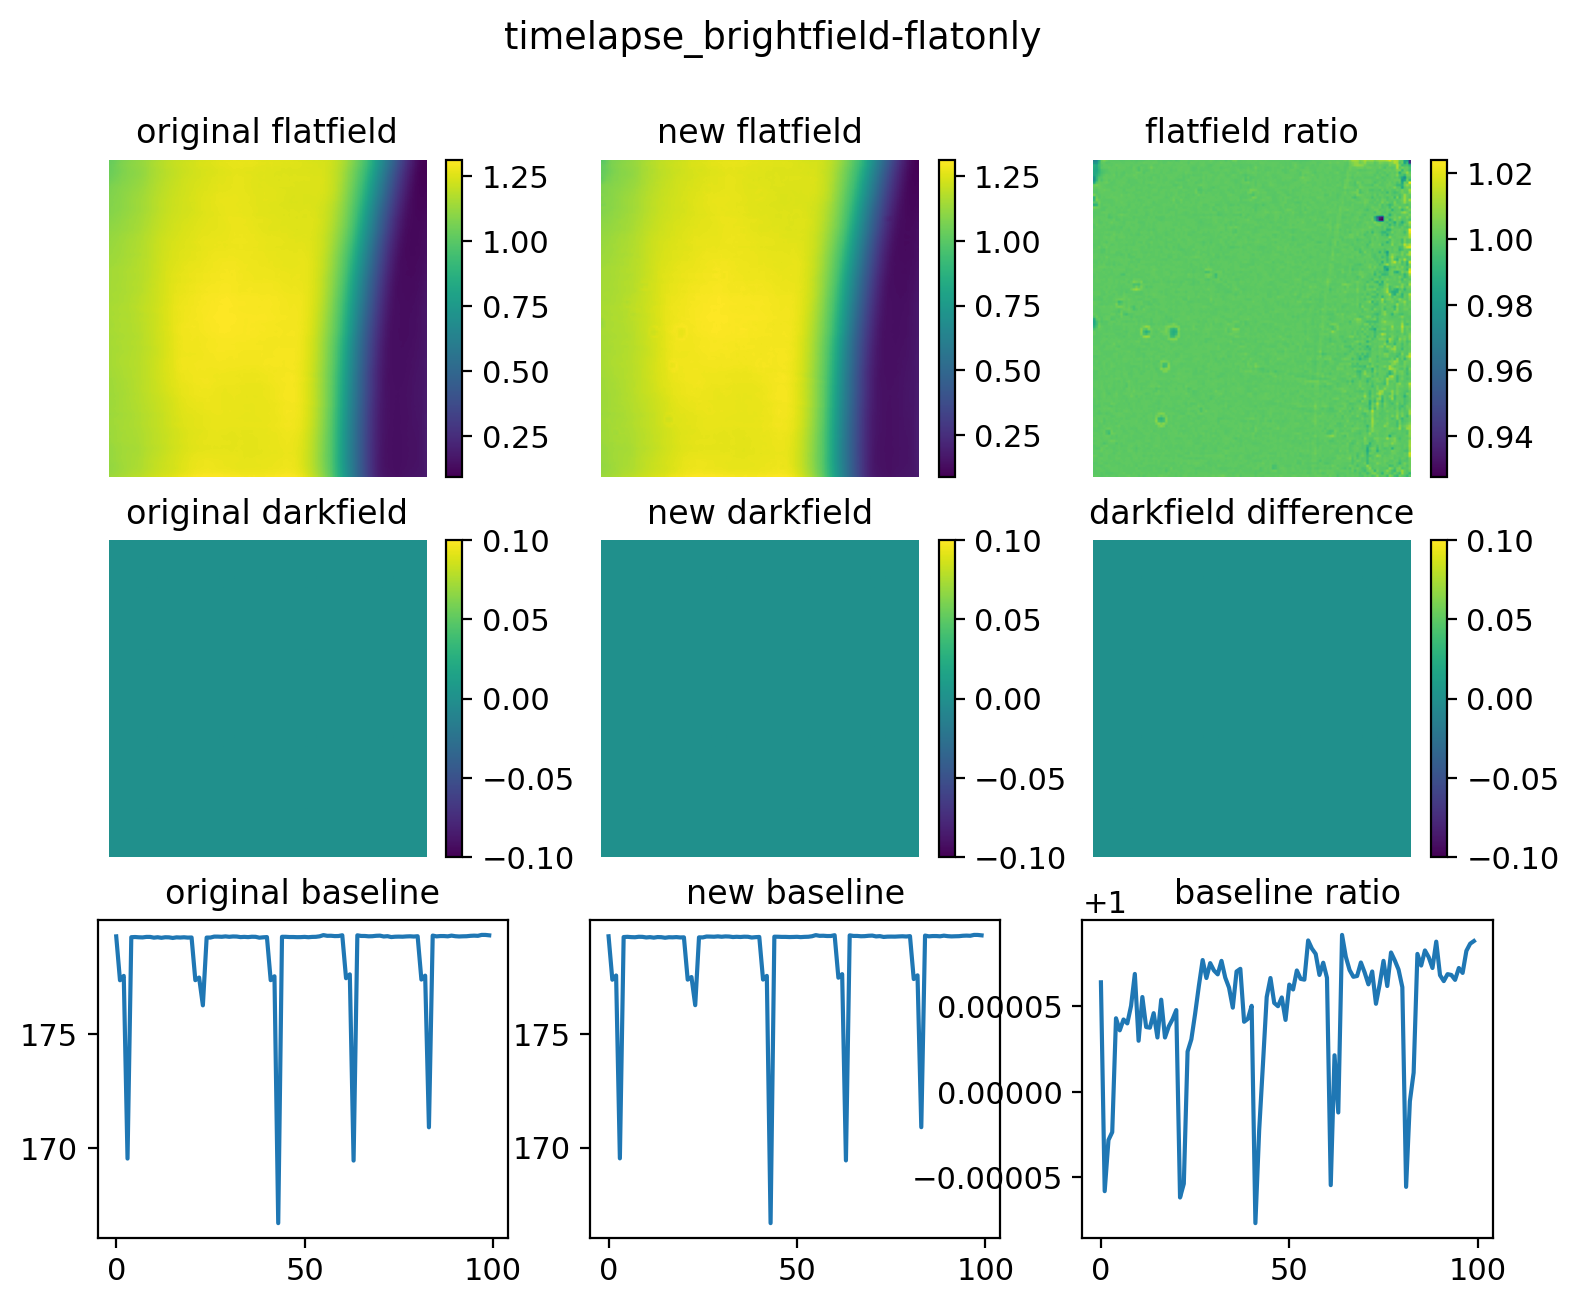

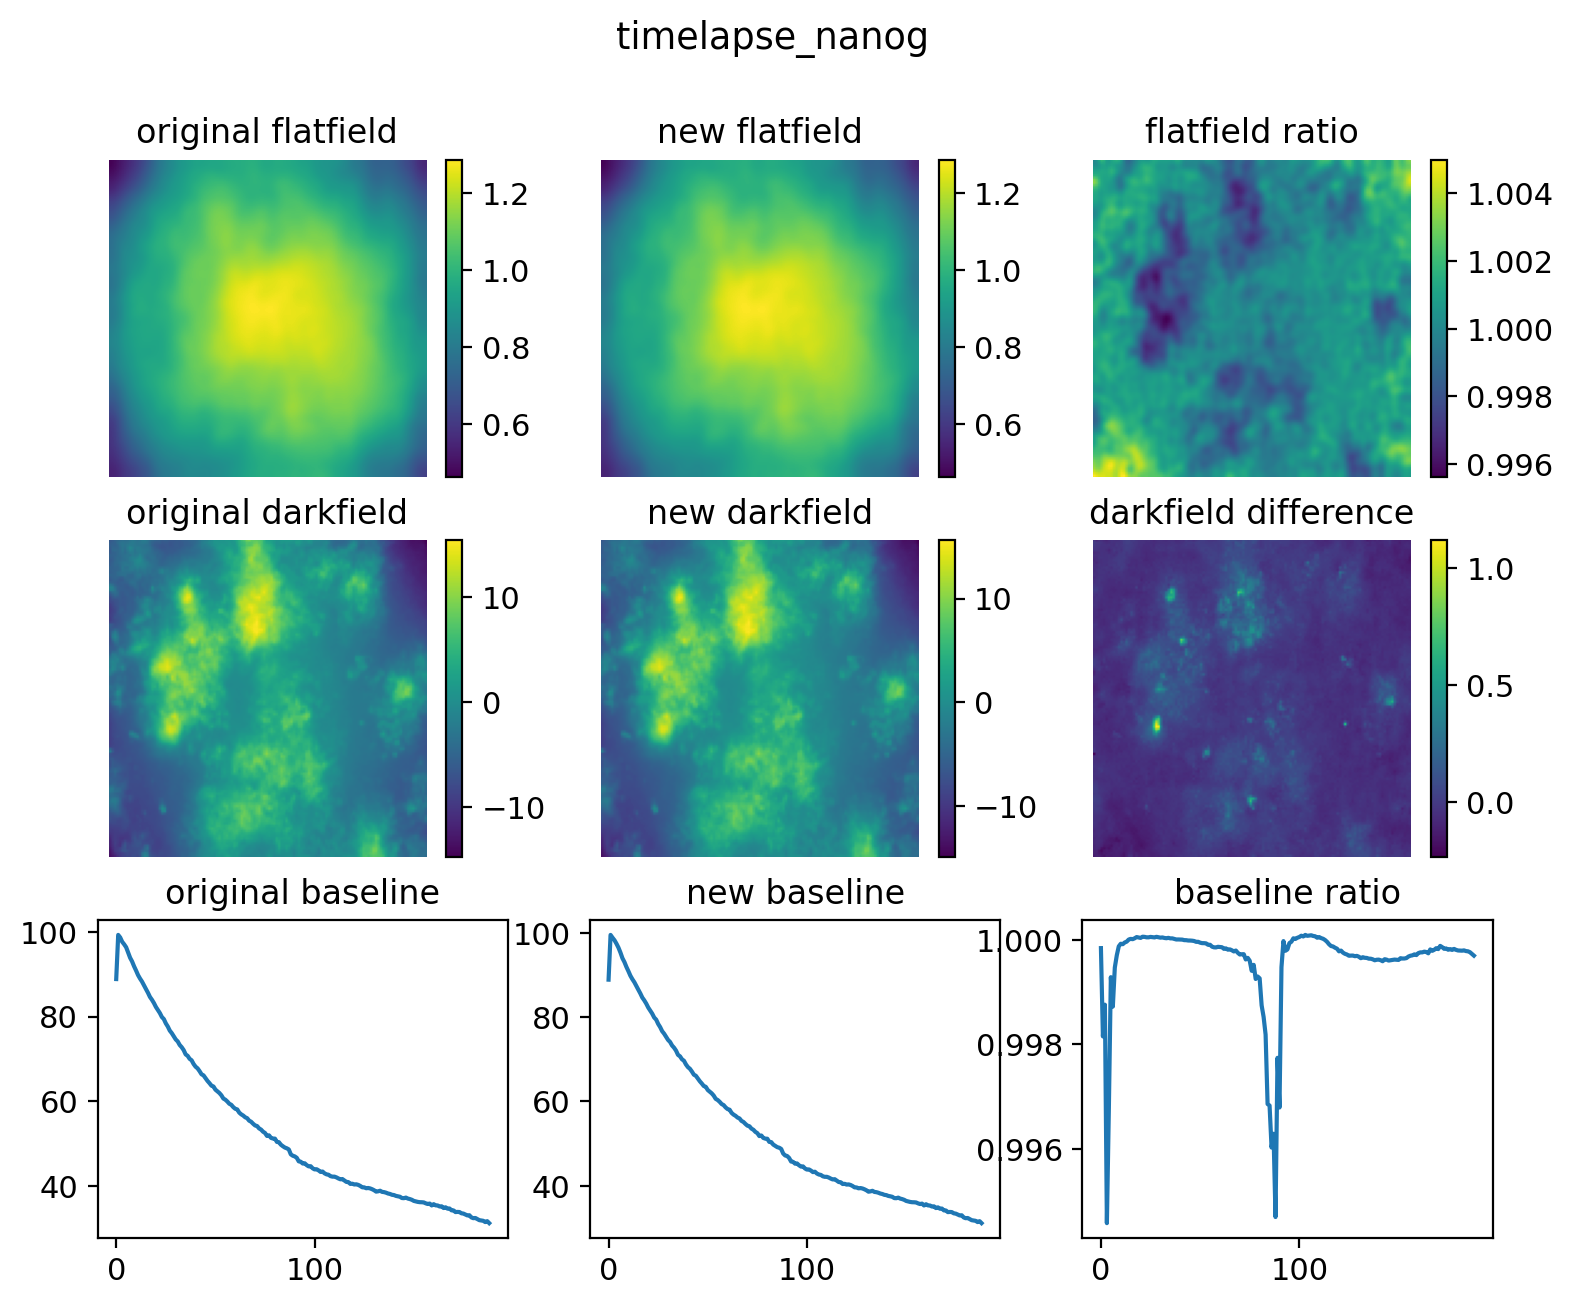

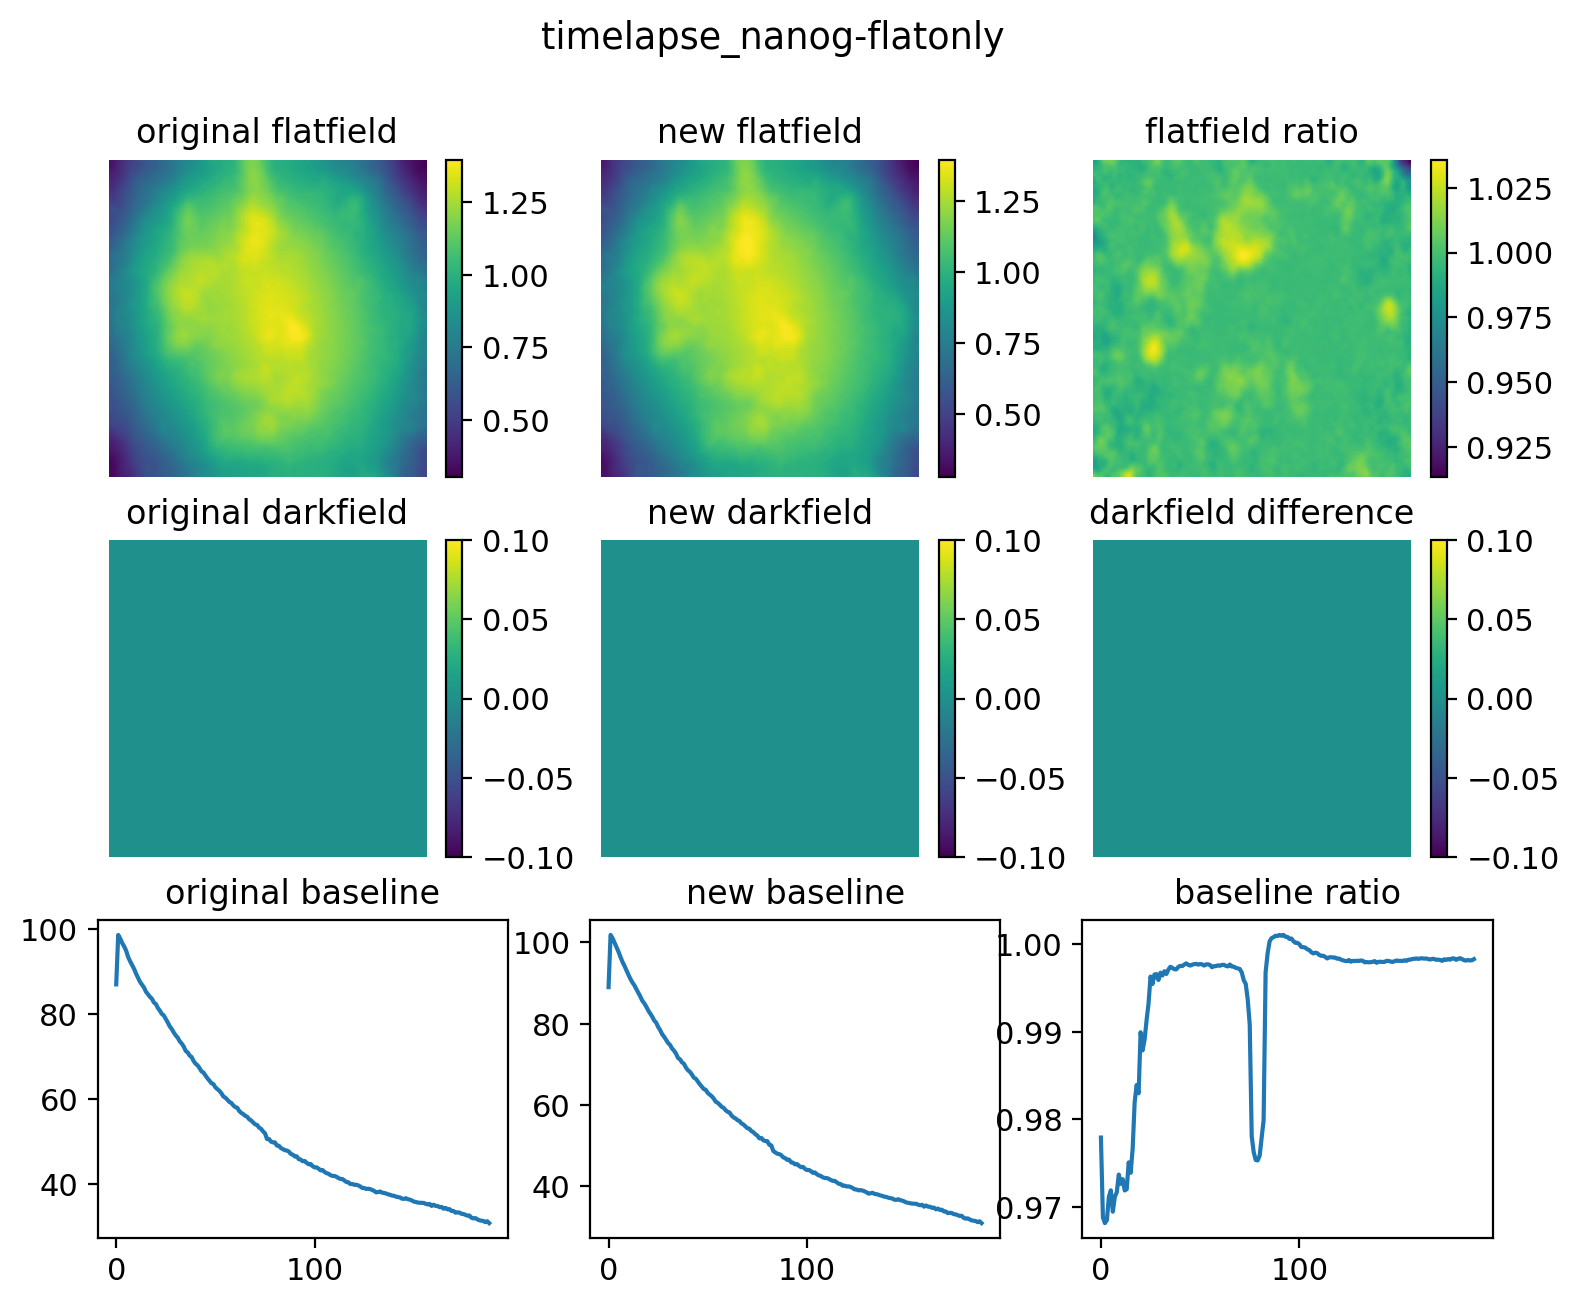

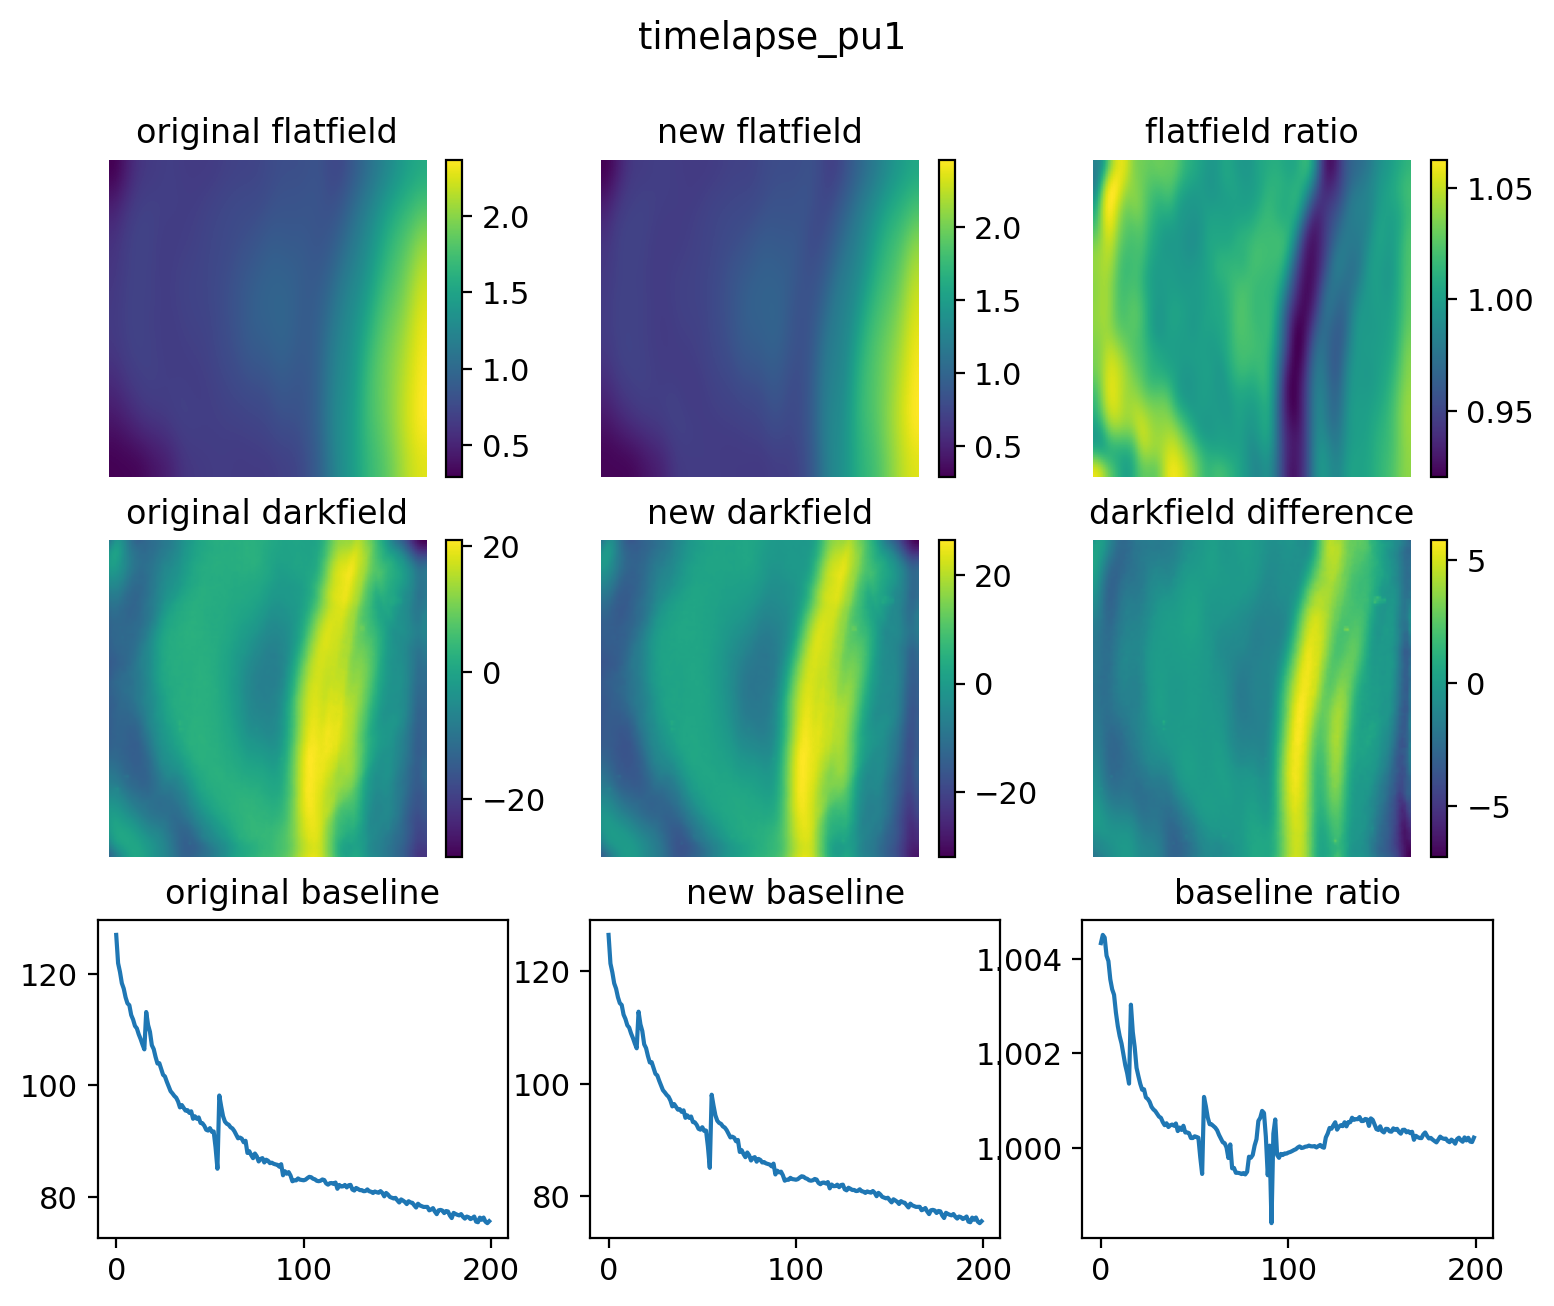

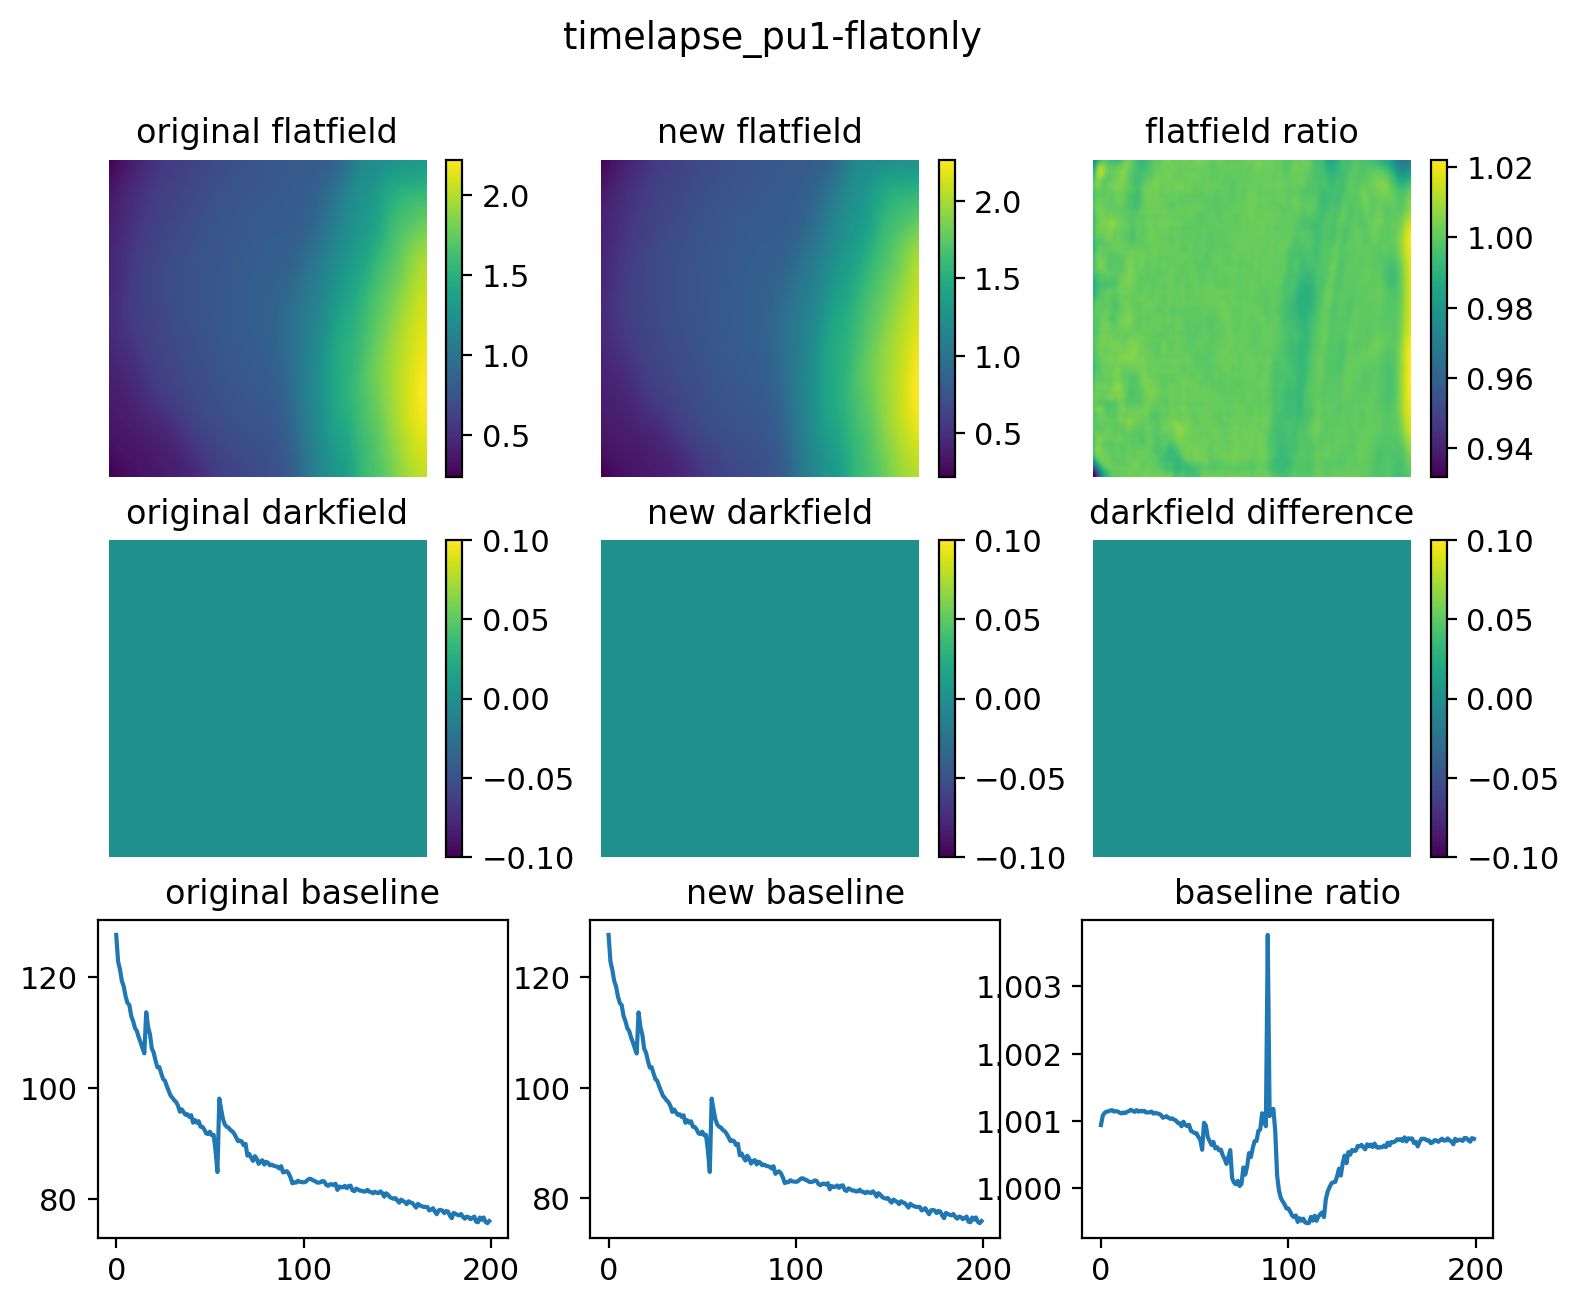

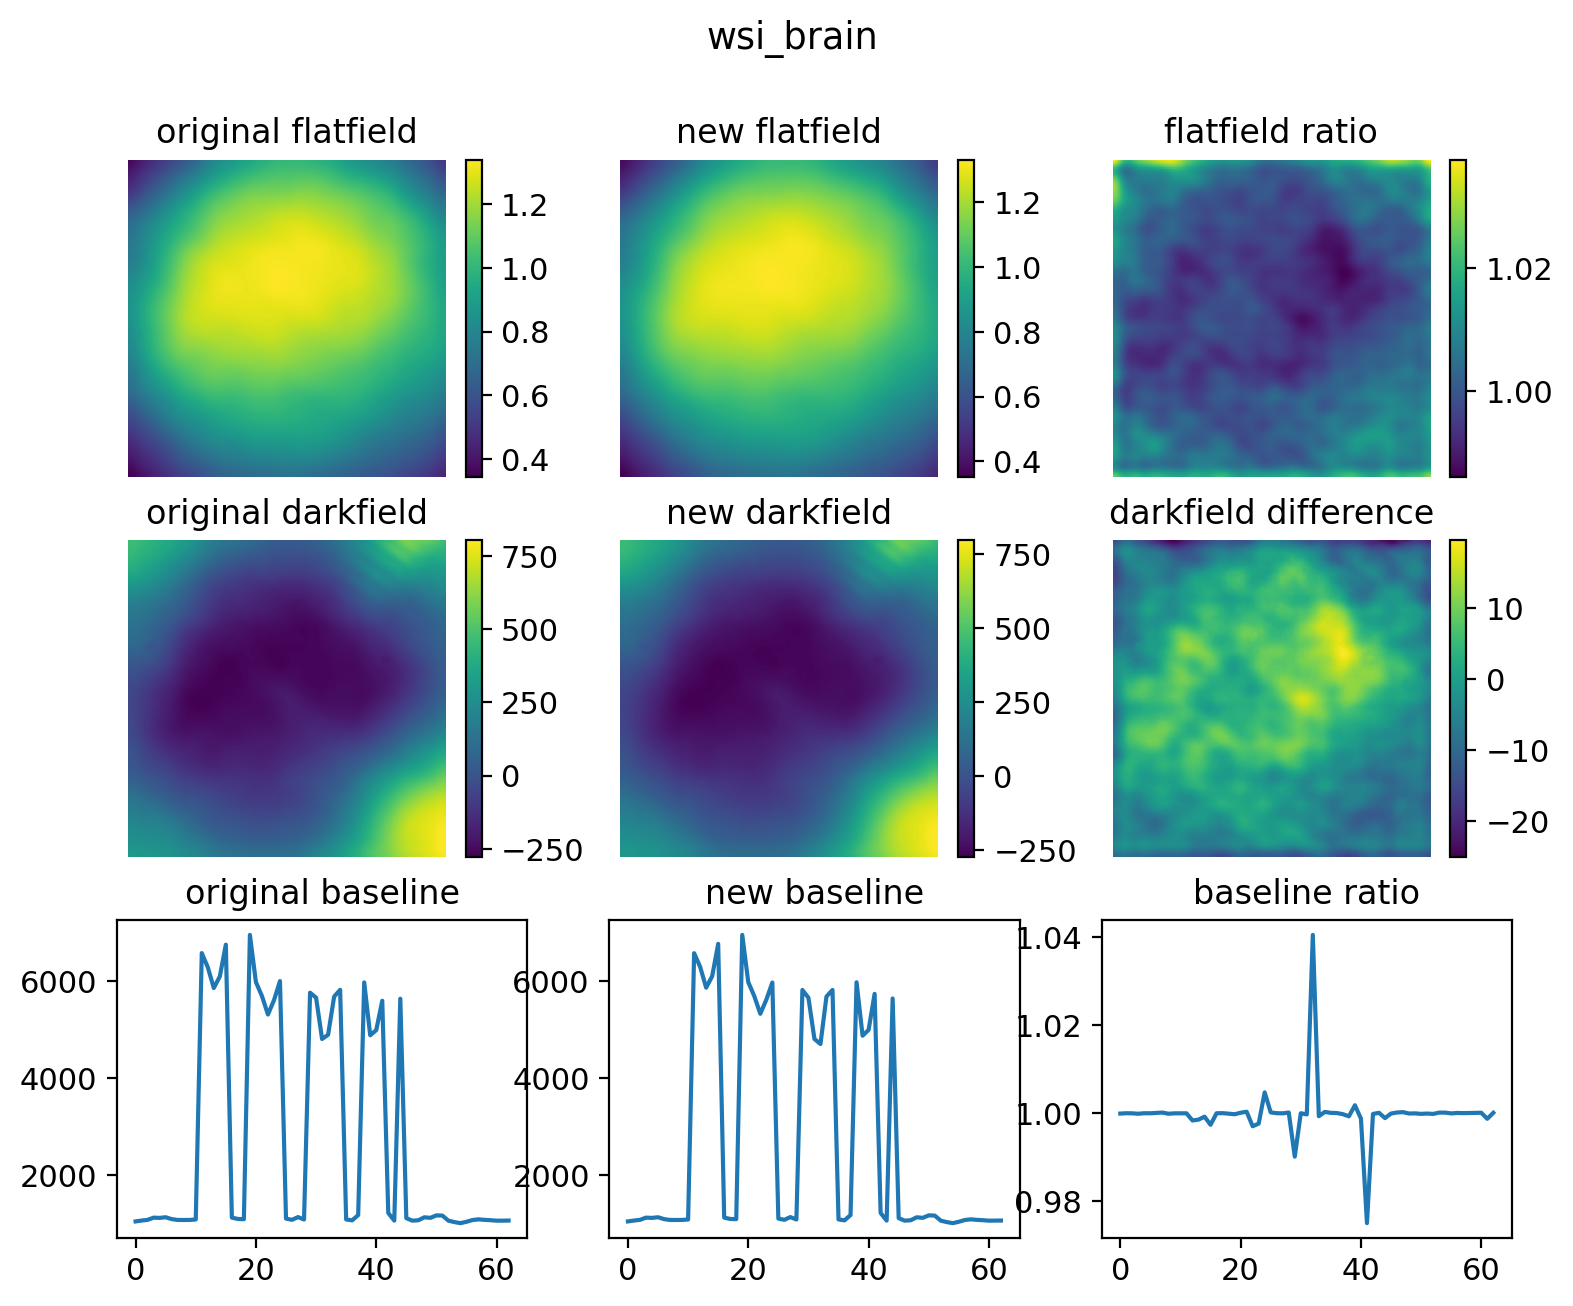

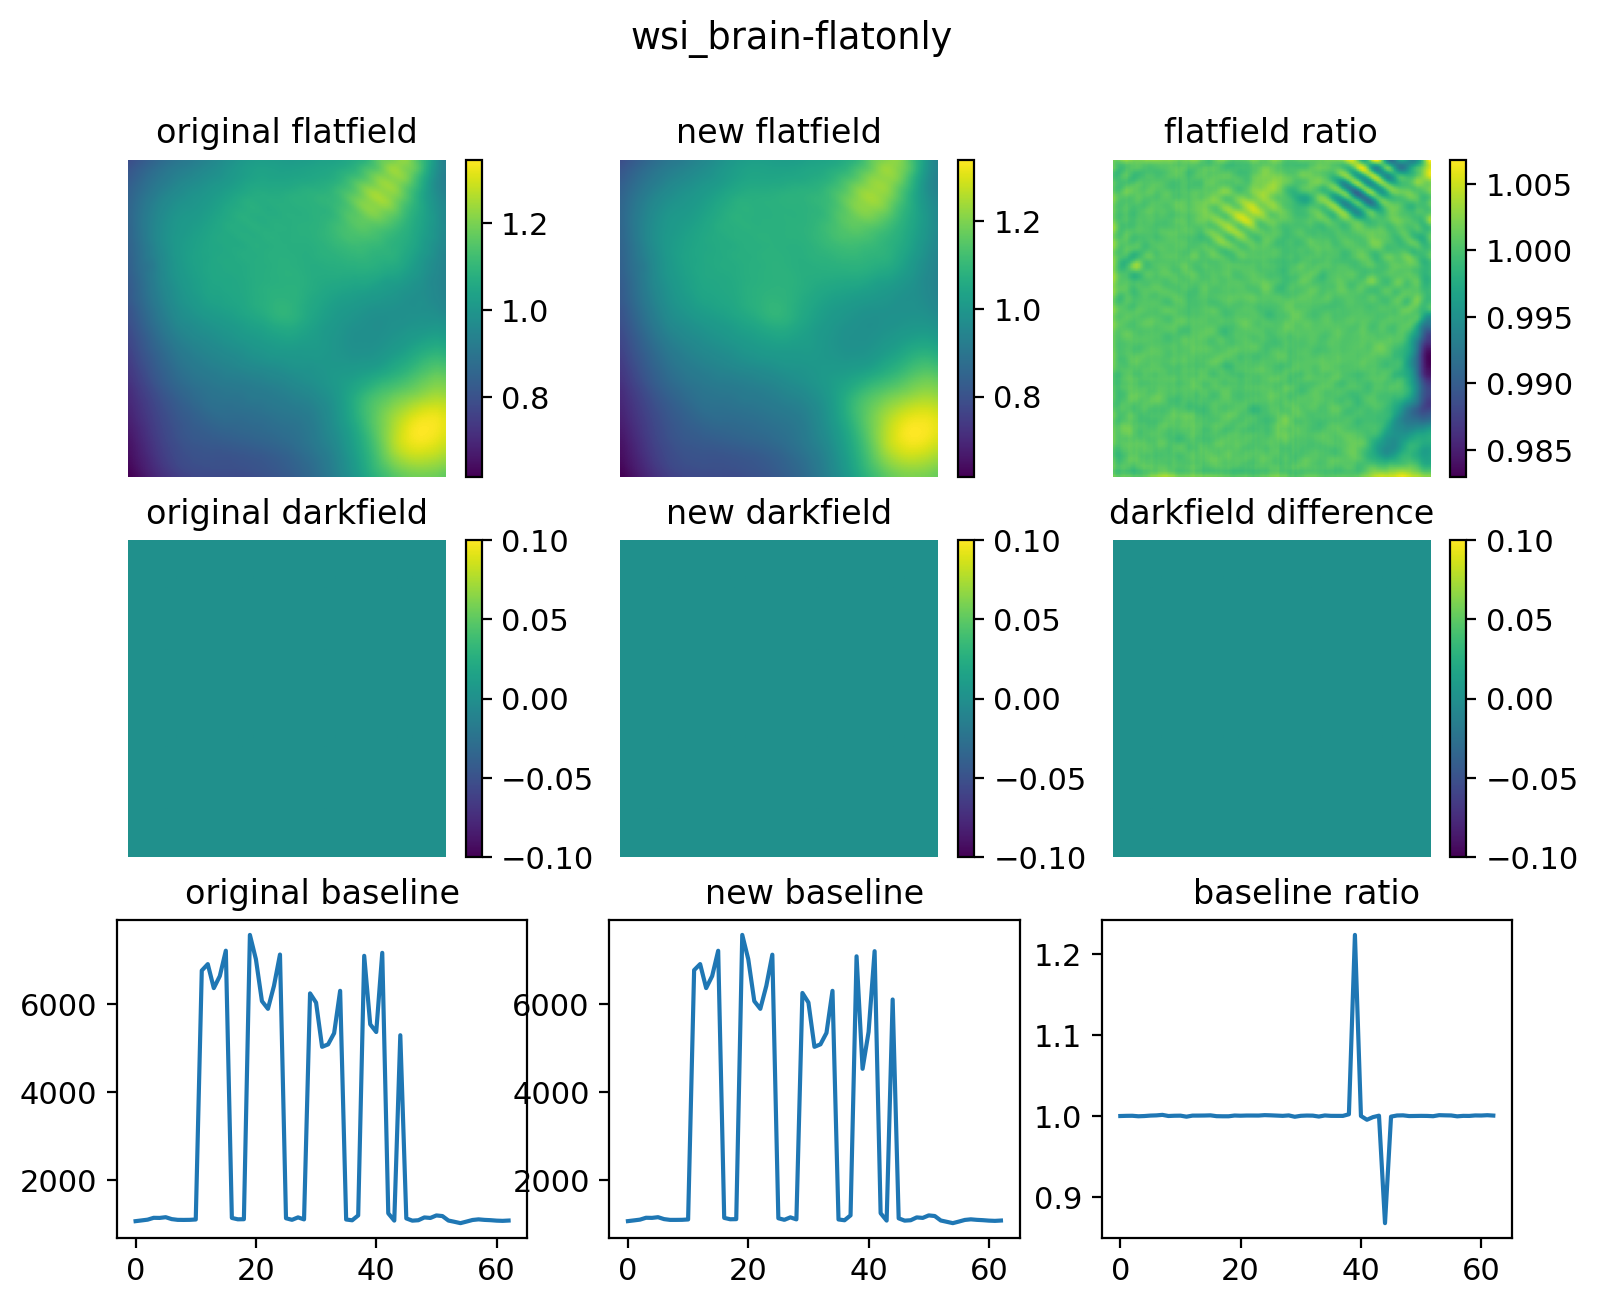

In [17]:
from basicpy import BaSiC

for k,images in list(imagess.items())[1:]:
    d=np.load(f"../data/reference_results.npz",allow_pickle=True)
    d=np.atleast_1d(d[k])[0]
    for get_darkfield in [True, False]:
        suffix="-flatonly" if not get_darkfield else ""
        flatfield_original = d["flatfield"+suffix]
        darkfield_original = d["darkfield"+suffix]
        baseline_original = d["baseline"+suffix]
        b = BaSiC(fitting_mode="approximate",
                    working_size=None,
                    get_darkfield=get_darkfield, 
                    
                    sort_intensity=True)
        b.fit(images)
        flatfield_new=b.flatfield
        darkfield_new=b.darkfield
        plotted_data=[
        flatfield_original,
        flatfield_new,
        flatfield_new/flatfield_original,
        darkfield_original,
        darkfield_new,
        darkfield_new-darkfield_original
        ]
        titles=[
        "original flatfield",
        "new flatfield",
        "flatfield ratio",
        "original darkfield",
        "new darkfield",
        "darkfield difference",
        ]

        fig, axes = plt.subplots(3, 3, figsize=(9,7))
        fig.suptitle(f"{k}{suffix}")
        for ax,data,t in zip(np.ravel(axes),plotted_data,titles):
            _im = ax.imshow(data)
            fig.colorbar(_im, ax=ax)
            ax.set_title(t)
            ax.axis("off")
        
        axes[2,0].plot(baseline_original)
        axes[2,1].plot(b.baseline)
        axes[2,2].plot(baseline_original/b.baseline)
        axes[2,0].set_title("original baseline")
        axes[2,1].set_title("new baseline")
        axes[2,2].set_title("baseline ratio")